# <u> Definición de muestras y coeficientes pre y post cuantización <u>

## Generación de muestras y cuantización

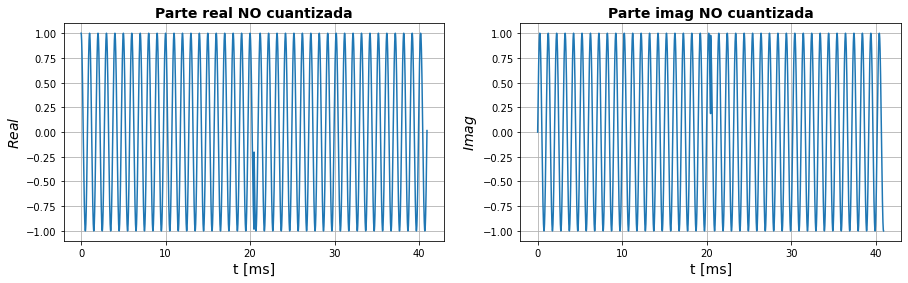

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tool._fixedInt import *
from scipy import signal
from random import *

show_plots = 1

N = 1024*4
fs   = 100e3
Ts   = 1/fs
n = np.arange(0,N)
t    = np.arange(0, N*Ts, Ts)
f    = 1e3

# Generación de muestras de entrada
real = []
imag = []

phase = np.pi/3
mixer_input = 1.0*(np.exp(1j*2*np.pi*f*n*Ts)*(n<N/2) + np.exp(1j*2*np.pi*f*Ts*n-1j*2*np.pi*f*phase)*(n>=N/2))

real = []
imag = []

for i in mixer_input:
    real.append(i.real)
    imag.append(i.imag)

# NB_INT  -> Número de bits de la parte entera
# NB_FRAC -> Número de bits de la parte fraccional
NB_INT = 16
NB_FRAC = 15

real_array = arrayFixedInt(NB_INT, NB_FRAC, real)
imag_array = arrayFixedInt(NB_INT, NB_FRAC, imag)

real_fixed = [i.fValue for i in real_array]
imag_fixed = [i.fValue for i in imag_array]

if show_plots:
    plt.figure(figsize = (15,4))
    plt.subplot(1,2,1)
    plt.plot(t/1e-3,real);
    plt.grid(True);
    plt.title("Parte real NO cuantizada", fontweight="bold", fontsize=14);
    plt.xlabel("t [ms]", fontsize=14); plt.ylabel("$Real$", fontsize=14);
    plt.subplot(1,2,2)
    plt.plot(t/1e-3,imag);
    plt.grid(True);
    plt.title("Parte imag NO cuantizada", fontweight="bold", fontsize=14);
    plt.xlabel("t [ms]", fontsize=14); plt.ylabel("$Imag$", fontsize=14);

## Generación de coeficientes de filtro IIR y PI

Coeficientes A: [0.999969482421875, 0.04998779296875, 0.248992919921875]
Coeficientes A HEXADECIMAL: ['7FFF', '0666', '1FDF']

Coeficientes B: [0.30999755859375, 0.54998779296875, 0.399993896484375]
Coeficientes B HEXADECIMAL: ['27AE', '4666', '3333']

Coeficientes Kp: 0.0999755859375
Coeficientes Kp HEXADECIMAL: 0CCC

Coeficientes Ki: 0.04998779296875
Coeficientes Ki HEXADECIMAL: 0666


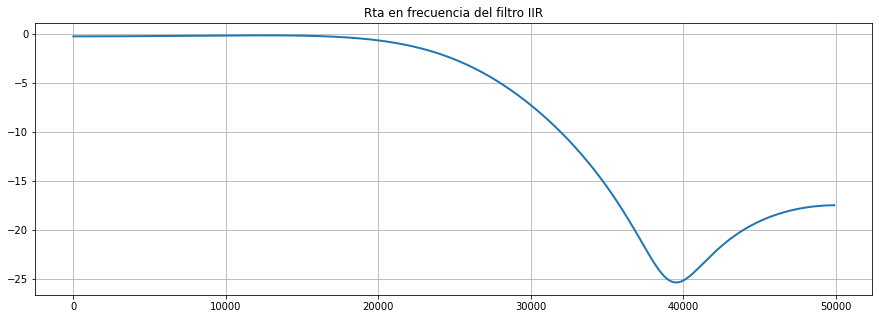

In [2]:
a_float = [1.0, 0.05, 0.249]
a_coef  = arrayFixedInt(NB_INT, NB_FRAC, a_float)
a = [i.fValue for i in a_coef]

b_float = [0.31, 0.55, 0.4]
b_coef  = arrayFixedInt(NB_INT, NB_FRAC, b_float)
b = [i.fValue for i in b_coef]

w,h = signal.freqz(b=b, a=a)
x = w*fs/(2*np.pi)
y = 20*np.log10(abs(h))

plt.figure(figsize=(15,5))
plt.plot(x,y, linewidth=2)
plt.title("Rta en frecuencia del filtro IIR")
plt.grid(True)


Kp_float = 0.1
Kp_fixed = DeFixedInt(NB_INT, NB_FRAC)
Kp_fixed.value = Kp_float
Kp = Kp_fixed.fValue

Ki_float = 0.05
Ki_fixed = DeFixedInt(NB_INT, NB_FRAC)
Ki_fixed.value = Ki_float
Ki = Ki_fixed.fValue

print(f"Coeficientes A: {a}")
print(f"Coeficientes A HEXADECIMAL: {[i.__hex__() for i in a_coef]}")

print(f"\nCoeficientes B: {b}")
print(f"Coeficientes B HEXADECIMAL: {[i.__hex__() for i in b_coef]}")

print(f"\nCoeficientes Kp: {Kp}")
print(f"Coeficientes Kp HEXADECIMAL: {Kp_fixed.__hex__()}")

print(f"\nCoeficientes Ki: {Ki}")
print(f"Coeficientes Ki HEXADECIMAL: {Ki_fixed.__hex__()}")

# <u> Generación de funciones de filtrado <u>

## Creacion de función de filtro IIR

In [3]:
def iir (x, y):
    partial_prod_B = [DeFixedInt(NB_INT, NB_FRAC), DeFixedInt(NB_INT, NB_FRAC), DeFixedInt(NB_INT, NB_FRAC)]
    partial_sum_B  = [DeFixedInt(NB_INT, NB_FRAC), DeFixedInt(NB_INT, NB_FRAC)]

    partial_prod_A = [DeFixedInt(NB_INT, NB_FRAC), DeFixedInt(NB_INT, NB_FRAC)]
    partial_sum_A  = [DeFixedInt(NB_INT, NB_FRAC), DeFixedInt(NB_INT, NB_FRAC)]
    
    # Forward
    partial_prod_B[0].value = b[0]*x[0] # (32,30) = (16,15)*(16,15)
    partial_prod_B[1].value = b[1]*x[1] # (32,30) = (16,15)*(16,15)
    partial_prod_B[2].value = b[2]*x[2] # (32,30) = (16,15)*(16,15)
    
    partial_sum_B[1].value  = partial_prod_B[2].fValue + partial_prod_B[1].fValue # (17,15) = (16,15) + (16,15)
    partial_sum_B[0].value  = partial_prod_B[0].fValue + partial_sum_B[1].fValue  # (17,15) = (16,15) + (16,15)
    
    # Feedback
    partial_prod_A[0].value = (-1)*a[1]*y[1]    # (32,30) = (16,15)*(16,15)
    partial_prod_A[1].value = (-1)*a[2]*y[2]    # (32,30) = (16,15)*(16,15)
    
    partial_sum_A[1].value  = partial_prod_A[0].fValue + partial_prod_A[1].fValue # (17,15) = (16,15) + (16,15)
    partial_sum_A[0].value  = partial_sum_A[1].fValue  + partial_sum_B[0].fValue  # (17,15) = (16,15) + (16,15)
    
    return partial_sum_A[0].fValue

## Creación de filtro PI

In [4]:
def PI_filter(x,y):
    partial_prod = [DeFixedInt(NB_INT, NB_FRAC), DeFixedInt(NB_INT, NB_FRAC)]
    partial_sum  = [DeFixedInt(NB_INT, NB_FRAC), DeFixedInt(NB_INT, NB_FRAC)]
    
    # Forward
    partial_prod[0].value = (Ki- Kp)*x[0]
    partial_prod[1].value = Kp*x[1]

    partial_sum[0].value  = partial_prod[0].fValue + partial_prod[1].fValue
    
    # Feedback
    partial_sum[1].value  = partial_sum[0].fValue  + y[1]
    
    return partial_sum[1].fValue

## Creación de operador partel real

In [5]:
def real_part(x):
    out  = DeFixedInt(NB_INT, NB_FRAC)
    
    out.value = x[0] + x[2]
    return out.fValue

# <u> Filtrado <u>

Valor en hexa de condicion inicial: 0CCC


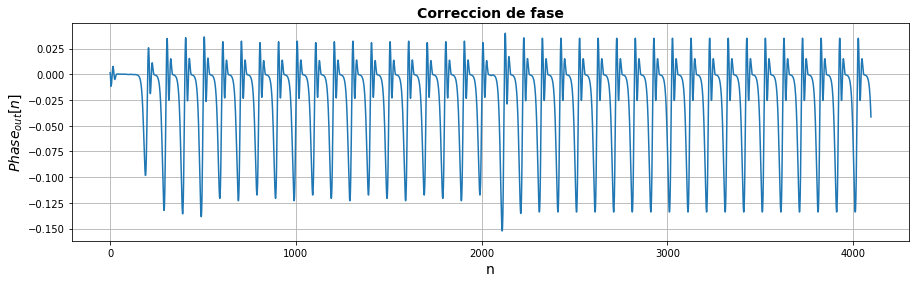

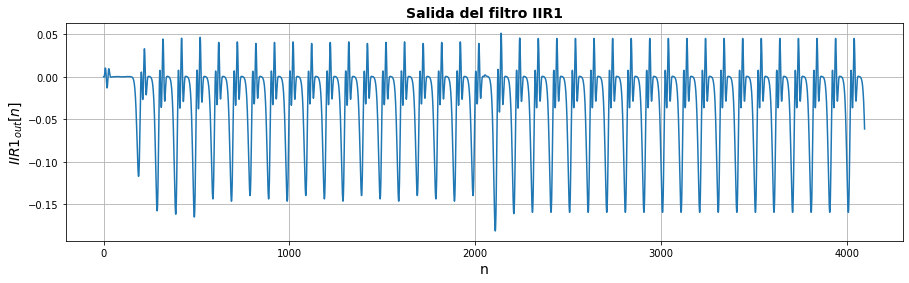

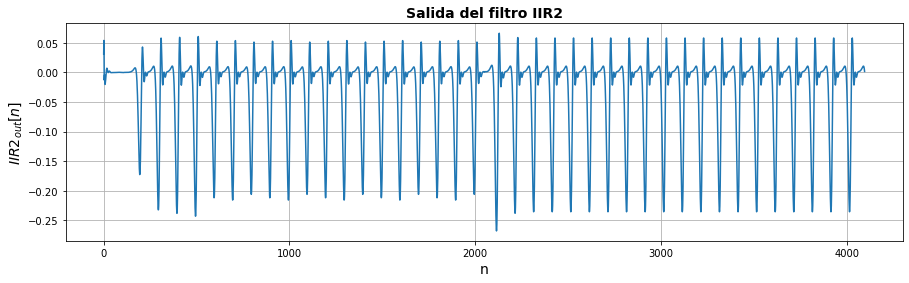

In [6]:
show_out = 1
print_values = 0

out1 = []
out2 = []
x_shiftreg_real = [0.0, 0.0, 0.0]
y_shiftreg_real = [0.0, 0.0, 0.0]

x_shiftreg_imag = [0.0, 0.0, 0.0]
y_shiftreg_imag = [0.0, 0.0, 0.0]

x_shiftreg_realpart_real = [0.0, 0.0, 0.0]
x_shiftreg_realpart_imag = [0.0, 0.0, 0.0]


PI_in  = [0.0, 0.0]
PI_out = [0.0, 0.0]
PI     = DeFixedInt(NB_INT, NB_FRAC)
phase  = []

INITIAL_CONDITION = 0.1
accum = DeFixedInt(NB_INT, NB_FRAC)
accum.value = INITIAL_CONDITION
print(f"Valor en hexa de condicion inicial: {accum.__hex__()}");

temp  = DeFixedInt(NB_INT, NB_FRAC, roundMode='round', saturateMode='wrap')

for i,v in enumerate(real_fixed):
    # ******************* Filter REAL *******************
    temp.value = (accum.fValue+PI_out[1])*imag_fixed[i]*(-1)
    
    # X shiftreg_real
    x_shiftreg_real[2] = x_shiftreg_real[1]
    x_shiftreg_real[1] = x_shiftreg_real[0]
    x_shiftreg_real[0] = temp.fValue

    # Y shiftreg_real
    y_shiftreg_real[2] = y_shiftreg_real[1]
    y_shiftreg_real[1] = y_shiftreg_real[0]
    y_shiftreg_real[0] = iir(x_shiftreg_real, y_shiftreg_real)
    
    out1.append(y_shiftreg_real[0])

    # ******************* Filter IMAG *******************
    temp.value = (accum.fValue+PI_out[1])*real_fixed[i]

    # X shiftreg_real
    x_shiftreg_imag[2] = x_shiftreg_imag[1]
    x_shiftreg_imag[1] = x_shiftreg_imag[0]
    x_shiftreg_imag[0] = temp.fValue

    # Y shiftreg_real
    y_shiftreg_imag[2] = y_shiftreg_imag[1]
    y_shiftreg_imag[1] = y_shiftreg_imag[0]
    y_shiftreg_imag[0] = iir(x_shiftreg_imag, y_shiftreg_imag)

    out2.append(y_shiftreg_imag[0])

    # ******************* Real part operator *******************
    x_shiftreg_realpart_imag[2] = x_shiftreg_realpart_imag[1]
    x_shiftreg_realpart_imag[1] = x_shiftreg_realpart_imag[0]
    x_shiftreg_realpart_imag[0] = y_shiftreg_imag[0]

    x_shiftreg_realpart_real[2] = x_shiftreg_realpart_real[1]
    x_shiftreg_realpart_real[1] = x_shiftreg_realpart_real[0]
    x_shiftreg_realpart_real[0] = y_shiftreg_real[0]

    y1 = real_part(x_shiftreg_realpart_real)
    y2 = real_part(x_shiftreg_realpart_imag)

    # ******************* Filter PI *******************
    PI.value = y1 - y2
    PI_in[1] = PI_in[0]
    PI_in[0] = PI.fValue

    PI_out[1] = PI_out[0]
    PI_out[0] = PI_filter(PI_in, PI_out)
    
    phase.append(PI_out[0])

    # ******************* Acummulator *******************
    accum.value = PI_out[0]


phase_out = arrayFixedInt(NB_INT, NB_FRAC, phase)

real_mem = open("../real.hex", "w")
imag_mem = open("../imag.hex", "w")
outs_mem = open("../outs.hex", "w")

if (show_plots or show_out):
    plt.figure(figsize = (15,4))
    plt.plot(n,phase)
    plt.grid(True)
    plt.title("Correccion de fase", fontweight="bold", fontsize=14);
    plt.xlabel("n", fontsize=14); plt.ylabel("$Phase_{out}[n]$", fontsize=14);
    plt.show()

    plt.figure(figsize= (15,4))
    plt.plot(n,out1)
    plt.grid(True)
    plt.title("Salida del filtro IIR1", fontweight="bold", fontsize=14);
    plt.xlabel("n", fontsize=14); plt.ylabel("$IIR1_{out}[n]$", fontsize=14);
    plt.show()
    
    plt.figure(figsize= (15,4))
    plt.plot(n,out2)
    plt.grid(True)
    plt.title("Salida del filtro IIR2", fontweight="bold", fontsize=14);
    plt.xlabel("n", fontsize=14); plt.ylabel("$IIR2_{out}[n]$", fontsize=14);
    plt.show()

if print_values:
    print("Valores de salida para testear:")
for i in phase_out:
    if print_values:
        print(f"{i.__hex__()}")
    outs_mem.write(f"{i.__hex__()}\n")
outs_mem.close()

if print_values:
    print("\n\nValores de parte REAL para testear:")
for i in real_array:
    if print_values:
        print(f"{i.__hex__()}")
    real_mem.write(f"{i.__hex__()}\n")
real_mem.close()

if print_values:
    print("\n\nValores de parte IMAG para testear:")
for i in imag_array:
    if print_values:
        print(f"{i.__hex__()}")
    imag_mem.write(f"0x{i.__hex__()}\n")
imag_mem.close()
    
if print_values:
    print("\n\nValores de parte Kp para testear:")
    print(Kp_fixed.__hex__())
    print("\n\nValores de parte Ki para testear:")
    print(Ki_fixed.__hex__())

    print("\n\nValores de A para testear:")
    for i in a_coef:
        print(i.__hex__())

    print("\n\nValores de B para testear:")
    for i in b_coef:
        print(i.__hex__())